In [144]:
import pandas as pd
import numpy as np
import re
import string
import collections
import datetime 

data = pd.read_csv('bbc-text.csv')
stopwords = pd.read_csv('stopwords.txt', sep=" ", header=0).columns.values


def preprocess(line):
    line = line.lower()
    res = clean_punc_and_num(line)
    res = remove_words_less_than_2(res)
    res = remove_stopwords(res)
    return res

def clean_punc_and_num(line): 
    regex = re.compile('[^ a-zA-Z]')
    cleaned = regex.sub('', line)
    return  cleaned

def remove_words_less_than_2(line):
    regex = re.compile(r'\b\w{1,2}\b')
    cleaned = regex.sub('', line)
    return  cleaned

def remove_stopwords(line):
    words = line.split()
    return [w for w in words if w not in stopwords]
# set(regex.sub('', data.iloc[0,1]).split())
# set(clean_punc_and_num(data.iloc[0,1]).split())
# def preprocess(line):
# remove_words_less_than_2(clean_punc_and_num(data.iloc[1,1]))
d1 = datetime.datetime.now()
print('Preprocessing Starts at ', d1)
data['text'] = data['text'].map(lambda t : np.array(preprocess(t)))

# Count All Words in All Docs
word_counts = collections.Counter(np.concatenate(data.text))
print('Count All Words in All Docs is done')

# Cound Words in each Docs Seperately
count_term_in_docs = data.text.map(lambda t : collections.Counter(t))
print('Cound Words in each Docs Seperately is done')

# Count how many docs contain a word -- df_j
num_doc_have_term = pd.DataFrame(np.array([[0]] * len(word_counts.keys())).T, columns=list(word_counts.keys()))
def count(l):
    num_doc_have_term[l] += 1
data['text'].map(lambda l : count(l))
print('Count how many docs contain a word -- df_j is done')

# Initial V Matrix
v_matrix = np.zeros((data.shape[0], num_doc_have_term.shape[1]))

# Create term frequency matrix - frequency of word (j - column) in document (i - row) -- TF_ij
freq_term_in_doc = pd.DataFrame(v_matrix, columns=list(word_counts.keys()))    
for i in range(freq_term_in_doc.shape[0]):
    freq_term_in_doc.iloc[i][list(count_term_in_docs[i].keys())] = list(count_term_in_docs[i].values())    
print('Create term frequency matrix - frequency of word (j - column) in document (i - row) -- df_j ,  is done')
    
# Create V Matrix

N = data.shape[0] + 1
second_term = np.log(N / num_doc_have_term.values[0]) + 1
for i in range(v_matrix.shape[0]):
#     first_term =  np.log(1 + freq_term_in_doc.iloc[i])
    first_term =  freq_term_in_doc.iloc[i]
    v_matrix[i] = first_term * second_term

print('Create V Matrix is done')

d2 = datetime.datetime.now()
print('Total run time = ', (d2-d1).total_seconds() / 60, ' Minutes')


Preprocessing Starts at  2021-05-09 22:40:46.141144
Count All Words in All Docs is done
Cound Words in each Docs Seperately is done
Count how many docs contain a word -- df_j is done
Create term frequency matrix - frequency of word (j - column) in document (i - row) -- df_j ,  is done
Create V Matrix is done
Total run time =  3.7743458666666667  Minutes


In [203]:
# np.savetxt("v_matrix.csv", v_matrix, delimiter=",")
# v_matrix = np.genfromtxt('v_matrix.csv', delimiter=',')

In [202]:
from tqdm.notebook import trange


def euclidean_distance(x,weights):
#     return np.array(list(map(np.linalg.norm, x - weights)))
    return x@weights.T

def index_of_minimum_distance(distances):
#     return np.argmin(distances)
    return np.argmax(distances)

def update_weights(lr, x, weights, w_index):
    delta_w = x - weights[w_index]
    weights[w_index] = weights[w_index] + lr * delta_w
    return weights

def one_step(X, weights, lr):
    for x in X:
        distances = euclidean_distance(x,weights)
#         print(distances)
        w_index = index_of_minimum_distance(distances)
#         print(w_index)
        weights = update_weights(lr, x, weights, w_index)
    return weights

def train(X, lr, epochs, num_of_labels):
    np.random.seed(1)
    weights = np.random.rand(num_of_labels, X.shape[1])
    for _ in trange(epochs):
        weights = one_step(X, weights, lr)
#         lr = 0.9 * lr
    return weights

In [239]:
labels = data.category.unique()
num_of_labels = data.category.unique().size
weights = train(v_matrix, 0.1, 1000, num_of_labels)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [263]:

def cluster(X, weights):
    results = {0:[], 1:[], 2:[], 3:[], 4:[]}
    for i, x in enumerate(X):
        distances = euclidean_distance(x,weights)
        w_index = index_of_minimum_distance(distances)
        results[w_index].append(i)
    return results

results = cluster(v_matrix, weights)
y_pred = np.zeros(data.shape[0])
for label, indices in results.items():
    y_pred[indices] = label

<BarContainer object of 5 artists>

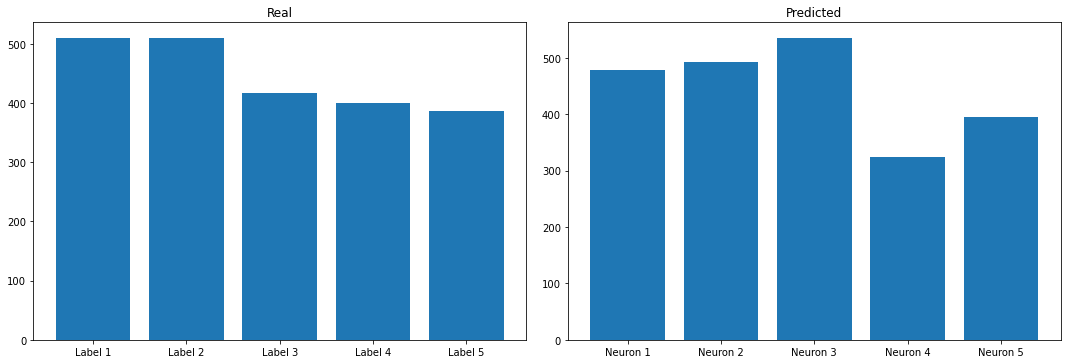

In [264]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
fig.tight_layout()

ax1.set_title('Real')
ax1.bar(list(range(5)), list(data.category.value_counts()),
        tick_label=['Label 1','Label 2','Label 3','Label 4','Label 5'],
        )


ax2.set_title('Predicted')
ax2.bar(list(range(5)), list(map(len, results.values())),
        tick_label=['Neuron 1','Neuron 2','Neuron 3','Neuron 4','Neuron 5'],
        )


<AxesSubplot:>

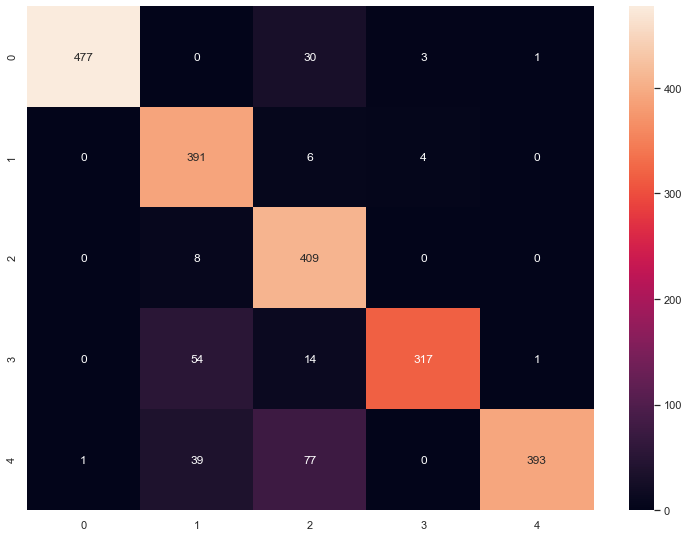

In [271]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
from matplotlib import rcParams
# print(data.category[list(results.values())[0]].value_counts())
# print("-----------------")
# print(data.category[list(results.values())[1]].value_counts())
# print("-----------------")
# print(data.category[list(results.values())[2]].value_counts())
# print("-----------------")
# print(data.category[list(results.values())[3]].value_counts())
# print("-----------------")
# print(data.category[list(results.values())[4]].value_counts())

# Sport -> 0, Tech -> 1, Politics -> 2, entertainment -> 3, business -> 4

def map_labels(l):
    if l == 'sport':
        return 0
    if l == 'tech':
        return 1
    if l == 'politics':
        return 2
    if l == 'entertainment':
        return 3
    if l == 'business':
        return 4
    
y_true = data.category.map(lambda l: map_labels(l))
sn.set(rc={'figure.figsize':(12.7,9.27)})
cf_matrix = confusion_matrix(y_true, y_pred)
sn.heatmap(cf_matrix, annot=True, fmt="d")